In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
import pickle
from typing import Dict, List

In [3]:
def results_to_df(proj_by_sample_ix: Dict[int, List[np.ndarray]]) -> pd.DataFrame: 
    all_dfs = []
    # Each model has an arbitrary sign convention for the eigenvectors.  
    # For the projection of Psi_2 (model j) onto Psi_2 (model i) make sure the first element is always positive
    
    for k, v in proj_by_sample_ix.items(): 
        data = {}
        ev_convention = (np.sign(v[0][0, :]))[np.newaxis, : ]

        n_cuts = v[0].shape[0]
        n_evs = v[0].shape[1]
        data['ev_sample'] = [k]*n_cuts*n_evs
        data['cut_ix'] = (np.cumsum(np.ones_like(v[0]), axis=0)).astype(int).flatten(order='F')
        data['ev_project'] = (1+np.cumsum(np.ones_like(v[0]), axis=1)).astype(int).flatten(order='F')    
        data['projection'] = (v[0]*ev_convention).flatten(order='F')
        all_dfs.append(pd.DataFrame(data))
    return pd.concat(all_dfs)

def collate_results(result_paths: List[Path]) -> pd.DataFrame: 
    all_dfs = []
    for path in result_paths: 
        bs_ix = int(path.stem)
        result = pickle.load(path.open('rb'))
        df = results_to_df(result)
        df['bs_ix'] = bs_ix
        all_dfs.append(df)
    return pd.concat(all_dfs)

def lb(x): 
    return np.quantile(x, 0.025)

def ub(x): 
    return np.quantile(x, 0.975)


def get_comparison(data_dir: Path, model_ix: int, sample_ix: int) -> pd.DataFrame: 
    proj_paths = list(data_dir.joinpath(f"hp_{model_ix}_ev_{sample_ix}").resolve().glob('*.pkl'))
    gtruth_paths = list(data_dir.joinpath(f"hp_{sample_ix}_ev_{sample_ix}").resolve().glob('*.pkl'))
    projections = collate_results(proj_paths)
    ground_truth = collate_results(gtruth_paths)

    comparison = pd.merge(left=ground_truth, right=projections, on=['ev_sample', 'cut_ix', 'ev_project', 'bs_ix'], how='inner', suffixes=['_true', '_est'])
    comparison.dropna(inplace=True)
    return comparison

def summarise_comparison(df: pd.DataFrame) -> pd.DataFrame: 
    df['sq_diff'] = (df['projection_true'] - df['projection_est'])**2
    summary_by_bs = df.groupby(['ev_sample', 'ev_project', 'bs_ix']).agg(rmse = ('sq_diff', lambda x: np.sqrt(np.mean(x))))
    summary = summary_by_bs.groupby(['ev_sample', 'ev_project']).agg([np.median, lb, ub])
    return summary

In [4]:
# md_t2 = {'1fme': 18*1000}
# order = [(53, 'fixed_k'), (60, 'fixed_k'), (52, 'fixed_k'), (47, 'worst'), (81, 'timescale_gap'), (60, 'timescale_gap'), (86, 'timescale_gap')]


In [5]:
protein = '1fme'

data_dir = Path('../data/msms/1fme/project_evs/')
out_dir = Path(f"{protein}")

models = [53, 60, 52, 47, 81, 86]
model_nums = [1, 2, 3, 4, 5, 7]
title_by_ix = {53: "1: Best (Dihedrals)", 60: '2: Best (Contacts)', 52: "3: Best (logit(contacts))", 47: '4: Worst (dihedrals)', 81: '5: Best gap (dihedrals)', 86: '7: Best gap (logit(contacts))' }
model_titles = [title_by_ix[i] for i in models]

## Example for explainer


In [6]:
i, j = 53, 86
proj_paths = list(data_dir.joinpath(f"hp_{i}_ev_{j}").resolve().glob('*.pkl'))
gtruth_paths = list(data_dir.joinpath(f"hp_{j}_ev_{j}").resolve().glob('*.pkl'))
projections = collate_results(proj_paths)
ground_truth = collate_results(gtruth_paths)
assert ground_truth.shape[0] == projections.shape[0]

comparison = pd.merge(left=ground_truth, right=projections, on=['ev_sample', 'cut_ix', 'ev_project', 'bs_ix'], how='outer', suffixes=['_true', '_est'])
assert comparison.shape[0] == ground_truth.shape[0]


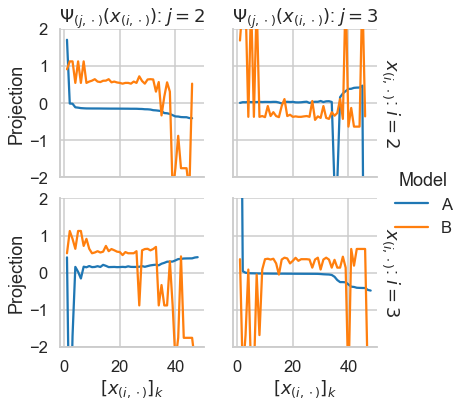

In [10]:
with sns.plotting_context('talk'): 
    tmp = comparison.query('bs_ix==11').copy()
    tmp.drop(labels=['bs_ix'], axis=1, inplace=True)
    
    tmp = tmp.melt(id_vars=['ev_sample', 'ev_project', 'cut_ix'], value_vars=['projection_true', 'projection_est'], var_name='type', value_name='Projection')
    
    new_by_old = {'ev_sample': '$x_{(i,\cdot)}$', 'ev_project': '$\Psi_{(j, \cdot)}(x_{(i, \cdot)})$', 'cut_ix': '$[x_{(i, \cdot)}]_{k}$'}
    tmp.rename(columns=new_by_old, inplace=True)
    tmp['Model'] = tmp['type'].apply(lambda x: 'A' if x=='projection_true' else 'B')
    
    g = sns.FacetGrid(data=tmp, row=new_by_old['ev_sample'], col=new_by_old['ev_project'], hue='Model', margin_titles=True)
    g.map(plt.plot, new_by_old["cut_ix"], "Projection").add_legend()
    g.set_titles(row_template="{row_var}: $i={row_name}$", col_template="{col_var}: $j={col_name}$")
    g.set(ylim=(-2, 2))
    sns.set_style('whitegrid')
    plt.savefig(out_dir.joinpath(f'projection_explainer_hp_{i}_sample_{j}.png'), dpi=300)

In [8]:
summaries = dict()
comparisons = dict()
for model_ix in models: 
    for sample_ix in models: 
        comp = get_comparison(data_dir, model_ix, sample_ix)
        comparisons[(model_ix, sample_ix)] = comp
        summary = summarise_comparison(comp)
        summaries[(model_ix, sample_ix)] = summary

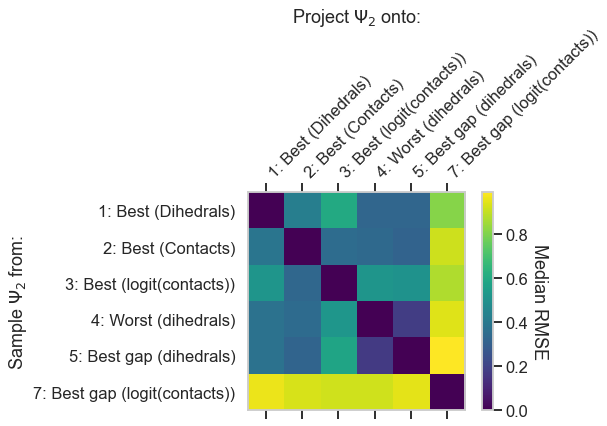

In [12]:
sample_ev, project_ev = 2, 2

mat = np.array([[summaries[(models[i], models[j])].loc[(sample_ev, project_ev), ('rmse', 'median')] for i in range(len(models))] for j in range(len(models))])


with sns.plotting_context('talk'): 
    fig, ax = plt.subplots()
    c = ax.matshow(mat, cmap='viridis')
    cbar = plt.colorbar(c)
    cbar.set_label('Median RMSE', rotation=270, labelpad=20)
    
    
    ax.grid(False)
    ax.set_xticks(np.arange(len(models)))

    ax.set_xticklabels(model_titles, rotation=45,  fontdict={'horizontalalignment': 'left'})
    ax.set_yticks(np.arange(len(models)))
    ax.set_yticklabels(model_titles, rotation='horizontal')
    ax.set_ylabel(f"Sample $\Psi_{{{sample_ev}}}$ from:")
    ax.set_xlabel(f'Project $\Psi_{{{sample_ev}}}$ onto:')
    ax.xaxis.set_label_position('top') 
    plt.savefig(out_dir.joinpath('ev_comparison_matrix.pdf'), bbox_inches='tight')